***
# Background and Approach
***

Data Source: https://github.com/basveeling/pcam</br>


The PatchCamelyon (PCam) benchmark is a new and challenging image classification dataset. It consists of thousands of color (RGB) images (96 x 96 x 3 pixels) extracted from histopathologic scans of lymph node sections. Each image is annoted with a binary label indicating presence of metastatic tissue. PCam provides a new benchmark for machine learning models: bigger than CIFAR10, smaller than imagenet, trainable on a single GPU.</br>

The aims of this final capstone project is to implement a relatively simple convolutional neural network (CNN) that will enable automatic binary classification of lymph node tissue with (binary label: 1) and without (binary label: 0) presence of metastatic tissue. The dataset contains a total of 262,144 images for training purposes, and 32,768 images for both model validation and testing.</br>

The approach taken is as follows:</br>

* Develop an external python function for flexible creation of a CNN. The function allows for user-specification of CNN hyperparameters including but not limited to activation functions, optimizers, learning rate and momentum as well as the number of CNN blocks. The CNN architecture is based on the Visual Geometry Group (VGG)-11 network architecture and the external function (VGG11Net.py) can be found here:  </br>

https://github.com/aprescot1977/Thinkful-projects/blob/main/VGG11Net.py

</br>


* Note that we will make use of the GPU-compatible version of Tensorflow (version 2.0.0) and the Keras API with all model training performed on a 11 GB NVIDIA GeForce RTX 2080 Ti GPU</br>
</br>


* To speed up our initial performance assessments, we initially will use a reduced dataset comprised of 80,000 images for training,  and 20,000 images for both validation and testing purposes. The reduced dataset is the focus of the present notebook. Once we have identified our most optimal model(s) we will move on to train the model using the full dataset in a separate notebook. That second notebook can be found here:</br>

https://github.com/aprescot1977/Thinkful-projects/blob/main/Prescot_PCAM_VGG11_FullData.ipynb


</br>


* A number of different VGG-11 models will be evaluated using different regularization techniques, learning rate schedules, batch sizes, and activation functions (hidden and output layers). Performance metrics will include model diagnostics based on training and validation loss, training and validation accuracy, test accuracy, confusion matrices, and the receiver operating curve (ROC) area under the curve (AUC).</br>
</br>


* Finally, once the most optimal model(s) are identified, we will apply the relevent hyperparameter settings to retrain the model on the full PCam dataset.


***
# Setup Environment
***

***
## Import Required Libraries
***

In [1]:
import os
import cv2
import gzip
import sys
import shutil
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import h5py
import matplotlib.pyplot as plt
from IPython.display import SVG
import VGGNet # user-defined function
import pydot as pyd
import time


import keras
from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score


%matplotlib inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf

Using TensorFlow backend.


***
## Create Session for Running TensorFlow Operations
***

Utilize the GPU version of TensorFlow and perform all (TF) operations on a 11GB NVIDIA GeForce RTX 2080 Ti GPU

In [2]:
print('TensorFlow version: {}'.format(tf.__version__) )

TensorFlow version: 2.0.0-rc1


In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [4]:
# Check GPU connection
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


***
# Image File Organization
***

Data Source: The data is stored in gzipped HDF5 files and can be downloaded at the following link: https://github.com/basveeling/pcam</br>

Six separate files are provided as follows:
* camelyonpatch_level_2_split_train_x.h5.gz  (train images)
* camelyonpatch_level_2_split_train_y.h5.gz  (train labels)
* camelyonpatch_level_2_split_valid_x.h5.gz  (validation images)
* camelyonpatch_level_2_split_valid_y.h5.gz  (validation labels)
* camelyonpatch_level_2_split_test_x.h5.gz   (test images)
* camelyonpatch_level_2_split_test_y.h5.gz   (test labels)</br>

We first need to unzip these files, read the h5 files and store image data and labels to numpy arrays:

In [5]:
# If the unzipped files already exist, this cell will be skipped
directory = "raw data"
for filename in os.listdir(directory):
    if filename.endswith("gz"):
        filename_unzip = filename.replace(".gz", "")
        if not os.path.exists(os.path.join(directory, filename_unzip)):
            with gzip.open(os.path.join(directory, filename), "rb") as f_in:
                with open(os.path.join(directory, filename_unzip), "wb") as f_out:
                    shutil.copyfileobj(f_in, f_out)

In [6]:
# Read h5 files and store to numpy arrays
truncate_size = 80000 # number of images for initial testing. We will use 80000 training files in the first instance

x_train_h5 = h5py.File(os.path.join(directory, 'camelyonpatch_level_2_split_train_x.h5'), 'r')
x_train = np.array(x_train_h5["x"][:])
y_train_h5 = h5py.File(os.path.join(directory, "camelyonpatch_level_2_split_train_y.h5"), "r")
y_train = np.array(y_train_h5["y"][:])

x_valid_h5 = h5py.File(os.path.join(directory, 'camelyonpatch_level_2_split_valid_x.h5'), 'r')
x_valid = np.array(x_valid_h5["x"][:])
y_valid_h5 = h5py.File(os.path.join(directory, "camelyonpatch_level_2_split_valid_y.h5"), "r")
y_valid = np.array(y_valid_h5["y"][:])

x_test_h5 = h5py.File(os.path.join(directory, 'camelyonpatch_level_2_split_test_x.h5'), 'r')
x_test = np.array(x_test_h5["x"][:])
y_test_h5 = h5py.File(os.path.join(directory, "camelyonpatch_level_2_split_test_y.h5"), "r")
y_test = np.array(y_test_h5["y"][:])

# truncate data for initial testing
x_train = x_train[0:truncate_size,]
y_train = y_train[0:truncate_size,]
x_valid = x_valid[0:int(truncate_size*0.250),]
y_valid = y_valid[0:int(truncate_size*0.250),]
x_test = x_train[0:int(truncate_size*0.250),]
y_test = y_train[0:int(truncate_size*0.250),]

Print out dimensions to get an idea of image sizes etc:

In [7]:
print('Training Size   (Images)  : {}'.format(x_train.shape))
print('Training Size   (Label)   : {}'.format(y_train.shape))
print('Validation Size (Images)  : {}'.format(x_valid.shape))
print('Validation Size (Label)   : {}'.format(y_valid.shape))
print('Test Size       (Images)  : {}'.format(x_test.shape))
print('Test Size       (Label)   : {}'.format(y_test.shape))

Training Size   (Images)  : (80000, 96, 96, 3)
Training Size   (Label)   : (80000, 1, 1, 1)
Validation Size (Images)  : (20000, 96, 96, 3)
Validation Size (Label)   : (20000, 1, 1, 1)
Test Size       (Images)  : (20000, 96, 96, 3)
Test Size       (Label)   : (20000, 1, 1, 1)


* There are 80,000 images/labels for training, and 20,000 images/labels for both the validation and test datasets. 
* Image resolution is 96 (pixels) x 96 (pixels) x 3 (RGB channels)

***
# Data Visualization
***

Define a function that will display 25 (random) labeled histopathological scans of human lymph node sections taken from the training set.

In [8]:
def draw_images(x, y, num_of_rows, num_of_columns):
    f, ax = plt.subplots(nrows = num_of_rows, ncols = num_of_columns,
                         figsize = (5 * num_of_columns, 5 * num_of_rows))
    
    num_of_images = len(x)
    sample_size = num_of_rows * num_of_columns
    idx = np.random.randint(num_of_images, size = sample_size)
    
    images = x[idx, :]
    labels = y[idx, :]
    
    k = 0
    for i in range(0, num_of_rows):
        for j in range(0, num_of_columns):
            ax[i, j].imshow(images[k])
            ax[i, j].set_title(labels[k, 0, 0, 0], fontsize = 16)
            sns.set_style()
            k += 1
            
    plt.show()

0: no tumor tissue
1: has tumor tissue


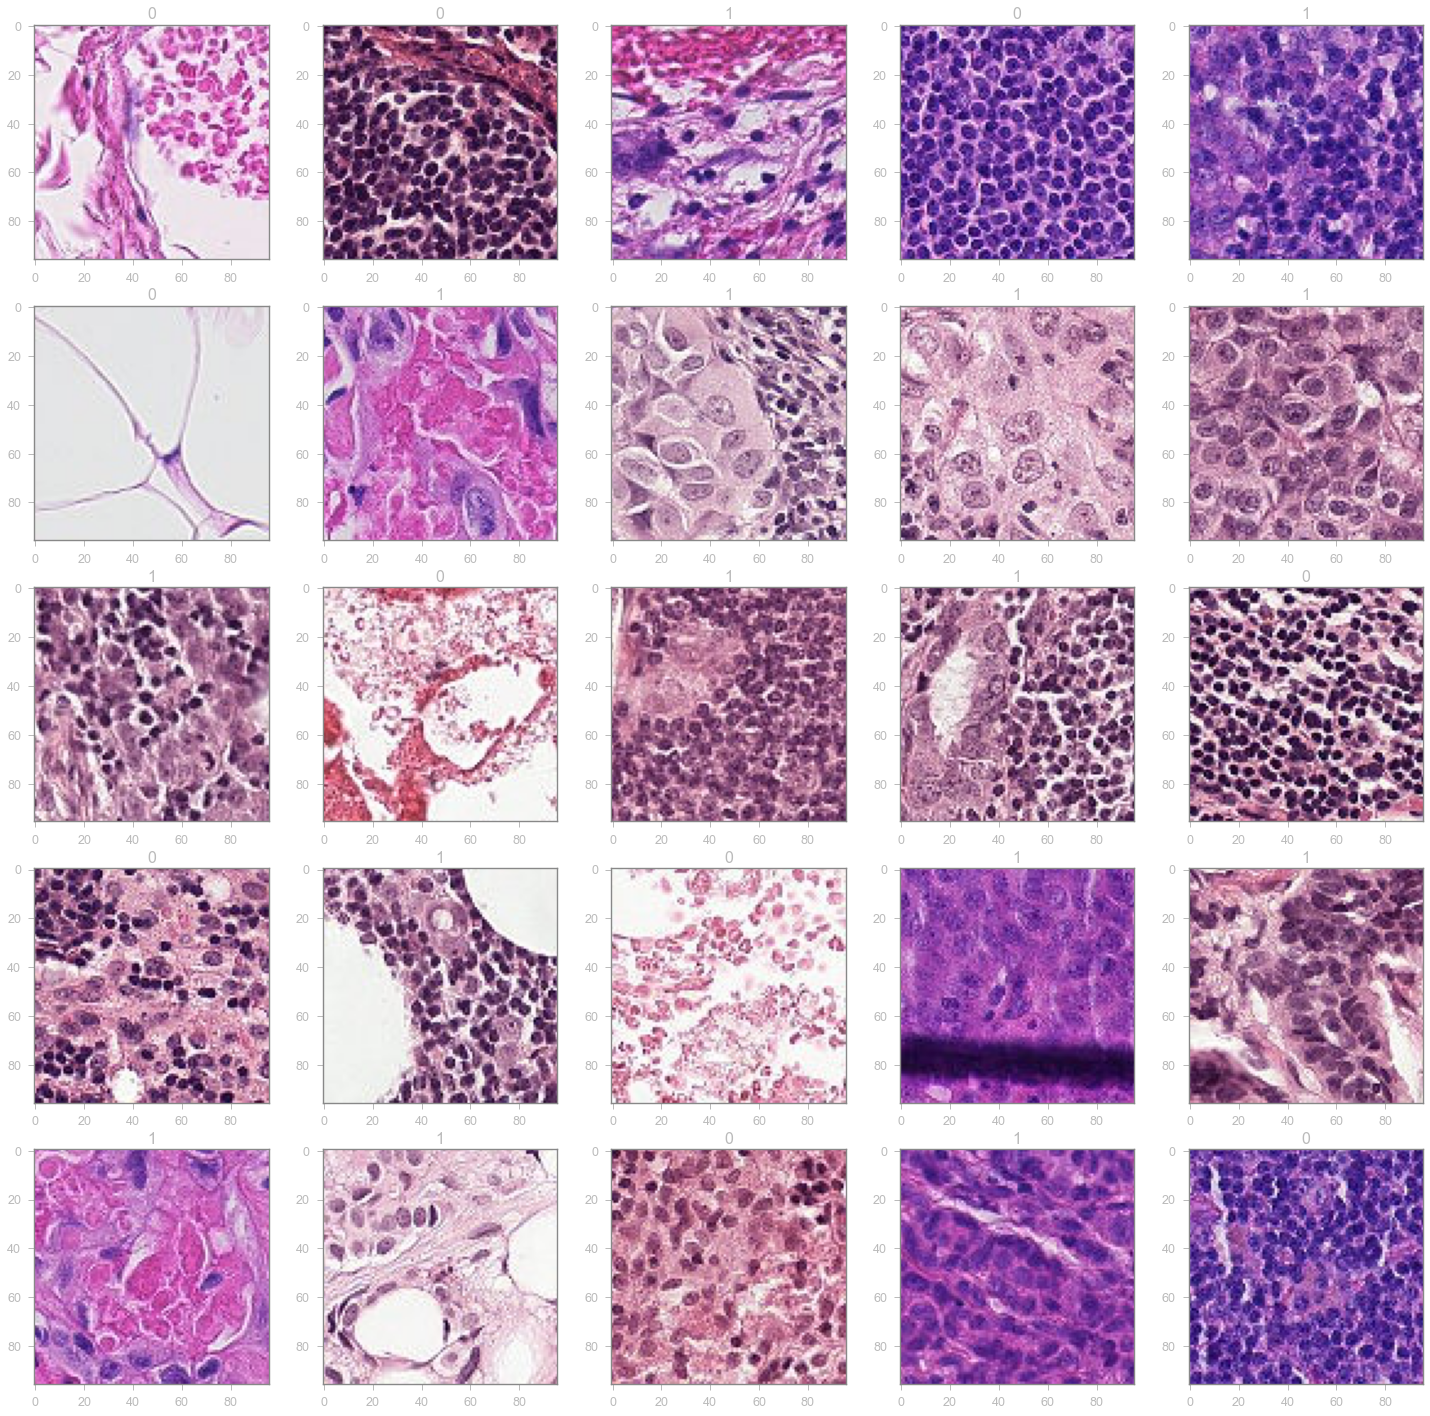

In [9]:
sns.set_style()
print("0: no tumor tissue")
print("1: has tumor tissue")
draw_images(x_train, y_train, 5, 5)

***
# Write Files to JPEG Format
***

The following cell contains conditional statements that check for the presence of train, validation, and test directories within the specified local base directory. If these have already been created (i.e. the first execution) then this none of the  folders will be recreated.

In [10]:
base_dir = 'final capstone pcam data'

if not os.path.exists(base_dir):
    os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

valid_dir = os.path.join(base_dir, 'valid')
if not os.path.exists(valid_dir):
    os.mkdir(valid_dir)
    
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
if not os.path.exists(no_tumor_tissue):
    os.mkdir(no_tumor_tissue)

has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
if not os.path.exists(has_tumor_tissue):
    os.mkdir(has_tumor_tissue)

no_tumor_tissue = os.path.join(valid_dir, 'a_no_tumor_tissue')
if not os.path.exists(no_tumor_tissue):
    os.mkdir(no_tumor_tissue)

has_tumor_tissue = os.path.join(valid_dir, 'b_has_tumor_tissue')
if not os.path.exists(has_tumor_tissue):
    os.mkdir(has_tumor_tissue)
    
no_tumor_tissue = os.path.join(test_dir, 'a_no_tumor_tissue')
if not os.path.exists(no_tumor_tissue):
    os.mkdir(no_tumor_tissue)

has_tumor_tissue = os.path.join(test_dir, 'b_has_tumor_tissue')
if not os.path.exists(has_tumor_tissue):
    os.mkdir(has_tumor_tissue)

***
The following cell then compares the length of the x_train, x_valid, and x_test numpy arrays with the number of files within the corresponding local base directory. If the lengths match, then jpeg files will not be rewritten.
***

In [11]:
if len(x_train) != len(os.listdir('final capstone pcam data/train/a_no_tumor_tissue')) + len(os.listdir('final capstone pcam data/train/b_has_tumor_tissue')):
    for i in range(len(x_train)):
        label = ""
        target = y_train[i, 0, 0, 0]
        if target == 0:
            label = 'a_no_tumor_tissue'
        elif target == 1:
            label = 'b_has_tumor_tissue'
        if label is not "":
            destination = os.path.join(train_dir, label, "{0}.jpg".format(i))
            cv2.imwrite(destination, x_train[i])

if len(x_valid) != len(os.listdir('final capstone pcam data/valid/a_no_tumor_tissue')) + len(os.listdir('final capstone pcam data/valid/b_has_tumor_tissue')):
    for i in range(len(x_valid)):
        label = ""
        target = y_valid[i, 0, 0, 0]
        if target == 0:
            label = 'a_no_tumor_tissue'
        elif target == 1:
            label = 'b_has_tumor_tissue'
        if label is not "":
            destination = os.path.join(valid_dir, label, "{0}.jpg".format(i))
            cv2.imwrite(destination, x_valid[i])
        
if len(x_test) != len(os.listdir('final capstone pcam data/test/a_no_tumor_tissue')) + len(os.listdir('final capstone pcam data/test/b_has_tumor_tissue')):
    for i in range(len(x_test)):
        label = ""
        target = y_test[i, 0, 0, 0]
        if target == 0:
            label = 'a_no_tumor_tissue'
        elif target == 1:
            label = 'b_has_tumor_tissue'
        if label is not "":
            destination = os.path.join(test_dir, label, "{0}.jpg".format(i))
            cv2.imwrite(destination, x_test[i])

***
# Definte Image Size, Batch Size, Epochs
***

In [26]:
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3

number_train_samples = len(x_train)
number_valid_samples = len(x_valid)

train_batch_size = 64
valid_batch_size = 64
epochs = 40

train_steps = np.ceil(number_train_samples / train_batch_size)
valid_steps = np.ceil(number_valid_samples / valid_batch_size)

print('Number of epochs = {}'.format(epochs))
print('Training steps   = {}'.format(int(train_steps)))
print('Validation steps = {}'.format(int(valid_steps)))

Number of epochs = 40
Training steps   = 1250
Validation steps = 313


***
# Define Train, Validation, and Testing Data Directories for Processing
***

In [13]:
train_path = 'final capstone pcam data/train'
valid_path = 'final capstone pcam data/valid'
test_path = 'final capstone pcam data/test'

datagen = ImageDataGenerator(rescale = 1.0/255) # Image preprocessing. Scaling RGB data.

train_gen = datagen.flow_from_directory(train_path,
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size = train_batch_size,
                                        class_mode = 'categorical')

valid_gen = datagen.flow_from_directory(valid_path,
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size = valid_batch_size,
                                        class_mode = 'categorical')

test_gen = datagen.flow_from_directory(test_path,
                                       target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                       batch_size = 1,
                                       class_mode = 'categorical',
                                       shuffle = False)

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


***
# Helper Functions
***

## Summarize Diagnostics

In [14]:
# plot diagnostic learning curves
def summarize_diagnostics(history, title):
    sns.set_style('darkgrid')

    # find maximum validation accuracy for vertical line display
    line = history.history['val_accuracy'].index(max(history.history['val_accuracy']))+1
    
    # loss plots
    plt.figure(figsize = (12, 10))
    plt.subplot(211)
    x_axis = list(range(1, len(history.history['accuracy']) + 1))
    sns.lineplot(x = x_axis, y = history.history['loss'],     color = 'b',      label = 'Training loss')
    sns.lineplot(x = x_axis, y = history.history['val_loss'], color = 'orange', label = 'Validation loss')
    plt.axvline(line, c = 'gray', linestyle = ':')
    plt.title('Model: ' + title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # accuracy plots
    plt.subplot(212)
    sns.lineplot(x = x_axis, y = history.history['accuracy'],     color = 'b',      label = 'Training accuracy')
    sns.lineplot(x = x_axis, y = history.history['val_accuracy'], color = 'orange', label = 'Validation accuracy')    
    plt.axvline(line, c = 'gray', linestyle = ':')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.savefig(title + '_diagnostics.png', facecolor='w')

## Performance Report and Confusion Matrix Calculation

In [15]:
def prediction_report(predictions, classes, test_gen):
    print(test_gen.class_indices)
    df_preds = pd.DataFrame(predictions, columns = classes)
    df_preds.head()
    y_true_labels = test_gen.classes
    y_predicted_labels = predictions.argmax(axis = 1)
    c_report = classification_report(y_true_labels, y_predicted_labels, target_names = classes)
    c_matrix = confusion_matrix(y_true_labels, y_predicted_labels)
    
    print(c_report)
    
    return c_matrix

## Confusion Matrix with ROC/AUC Plotter

In [16]:
def seaborn_cm(data_cm, bin0, bin1, title, test_gen, predictions): # Uses Seaborn's heatmap
    # Confusion Matrix
    plt.figure(figsize=(18,8))
    plt.subplot(121)
    sns.set_style('whitegrid')
    accuracy = np.trace(data_cm)/float(np.sum(data_cm))
    misclass = 1-accuracy
    cm2plot = pd.DataFrame(data_cm.T, columns = [bin0, bin1], index = [bin0, bin1])
    sns.heatmap(cm2plot, square = True, annot = True, fmt = "d", linecolor = 'grey', linewidths = 1, cmap = 'YlGnBu')
    plt.ylabel('Predicted Value')
    plt.xlabel('Ground Truth\n\naccuracy = {:0.3f}        misclass = {:0.3f}'.format(accuracy, misclass))
    plt.title('{}'.format(title))
    
    # ROC Plot
    plt.subplot(122)
    fpr, tpr, thresholds = roc_curve(test_gen.classes, predictions[:,1])
    auc_model = auc(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.plot(fpr, tpr, 'k', label='area = {:.3f}'.format(auc_model))
    plt.xlabel('False positive rate (1-specificity)')
    plt.ylabel('True positive rate (sensitivity)')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    plt.savefig(title + '_confusion_plot.png', facecolor='w')
    
    ''' remove comments below if CM has top and bottom clipped '''
    #b, t = plt.ylim() # find the values for bottom and top
    #b += 0.5 # Add 0.5 to the bottom
    #t -= 0.5 # Subtract 0.5 from the top
    #plt.ylim(b, t) # update the ylim(bottom, top) values

## Model Plotter

In [17]:
def model_plotter(model, filename):
    keras.utils.vis_utils.pydot = pyd
    plot_model(model, to_file = filename)
    SVG(model_to_dot(model).create(prog = 'dot', format = 'svg'))

***
# Visual Geometry Group (VGG) Net
***

To keep the present notebook succinct, we will use a user-defined VGG11Net.py function to load our various CNNs (function source: https://drive.google.com/file/d/1uu-F00_S6dC5X3eRi0MMSO8ZhuTjklvf/view?usp=sharing). First, we will investigate the performance of a simple VGG11-Net CNN architecture characterized by the follwing parameters:</br>

epochs = 40</br>

batchsize = 64</br>

optimizer = SGD (stochastic gradient descent)</br>

learning rate = 0.001</br>

momentum = 0.9</br>

hidden/dense layer activation = relu (rectified linear unit)</br>

output activation = softmax</br>



***
## Basic VGG-11
***

### Instantiate and Plot Model

In [27]:
import VGG11Net
# Instantiate Model
model_vgg11 = VGG11Net.CNN_BASIC_VGG11((IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS))
model_vgg11.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 96, 96, 64)        1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 256)       295168    
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 256)       590080    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 256)      

In [28]:
# Plot model
model_plotter(model_vgg11, 'model_vgg11.png')

### Specify Model Filename and Create Checkpoint

In [29]:
filepath = "model_vgg11.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_accuracy',
                             verbose = 1, 
                             save_best_only = True,
                             mode = 'max')
callbacks_list = [checkpoint]

### Train Model

In [30]:
start_time = time.time()
history_vgg11 = model_vgg11.fit_generator(generator = train_gen,
                                     steps_per_epoch = train_steps,
                                     validation_data = valid_gen,
                                     validation_steps = valid_steps,
                                     epochs = epochs,
                                     verbose = 1,
                                     callbacks = callbacks_list)
print('Run time for {} epochs: {:.2f} minutes'.format(20, (1/60)*(time.time()-start_time)))

Epoch 1/40
1250/1250 [==============================] - 81s 65ms/step - loss: 15.6698 - accuracy: 0.7633 - val_loss: 15.2309 - val_accuracy: 0.7499

Epoch 00001: val_accuracy improved from -inf to 0.74990, saving model to model_vgg11.h5
Epoch 2/40
1250/1250 [==============================] - 103s 82ms/step - loss: 14.8811 - accuracy: 0.7993 - val_loss: 14.3898 - val_accuracy: 0.7955

Epoch 00002: val_accuracy improved from 0.74990 to 0.79555, saving model to model_vgg11.h5
Epoch 3/40
1250/1250 [==============================] - 111s 89ms/step - loss: 14.1540 - accuracy: 0.8125 - val_loss: 13.7724 - val_accuracy: 0.8053

Epoch 00003: val_accuracy improved from 0.79555 to 0.80530, saving model to model_vgg11.h5
Epoch 4/40
1250/1250 [==============================] - 84s 67ms/step - loss: 13.4683 - accuracy: 0.8211 - val_loss: 13.0209 - val_accuracy: 0.8072

Epoch 00004: val_accuracy improved from 0.80530 to 0.80715, saving model to model_vgg11.h5
Epoch 5/40
1250/1250 [===================

1250/1250 [==============================] - 80s 64ms/step - loss: 2.3211 - accuracy: 0.9922 - val_loss: 2.3897 - val_accuracy: 0.8350

Epoch 00040: val_accuracy did not improve from 0.85060
Run time for 20 epochs: 55.05 minutes


### Model Diagnostics

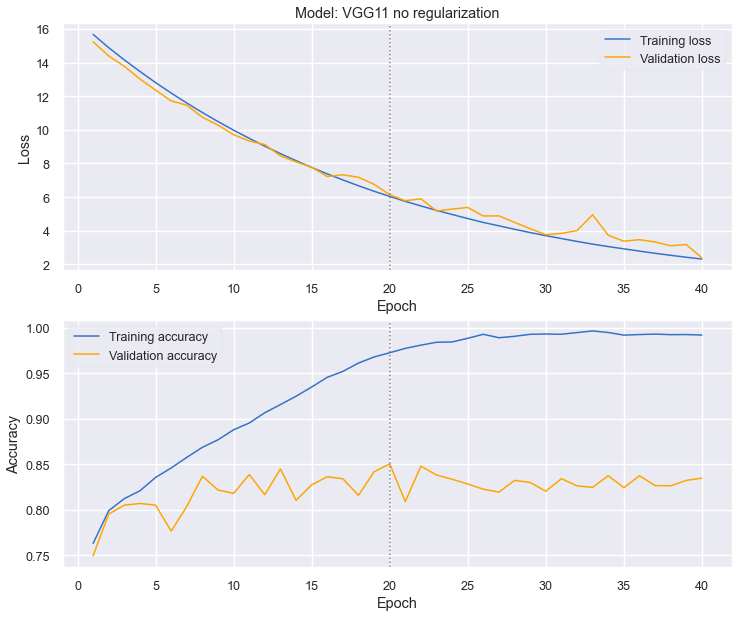

In [31]:
summarize_diagnostics(history_vgg11, 'VGG11 no regularization')

### Predictions and Report on Test Data

In [32]:
# Load model parameters
filepath = "model_vgg11.h5"
model_vgg11.load_weights(filepath)
predictions = model_vgg11.predict_generator(test_gen, steps = len(x_test), verbose = 1)

20000/20000 [==============================] - 56s 3ms/step


In [33]:
classes = ['no tumor tissue', 'has tumor tissue']
c_matrix = prediction_report(predictions, classes, test_gen)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}
                  precision    recall  f1-score   support

 no tumor tissue       0.99      0.98      0.98      9915
has tumor tissue       0.98      0.99      0.98     10085

        accuracy                           0.98     20000
       macro avg       0.98      0.98      0.98     20000
    weighted avg       0.98      0.98      0.98     20000



### Confusion Matrix and ROC 

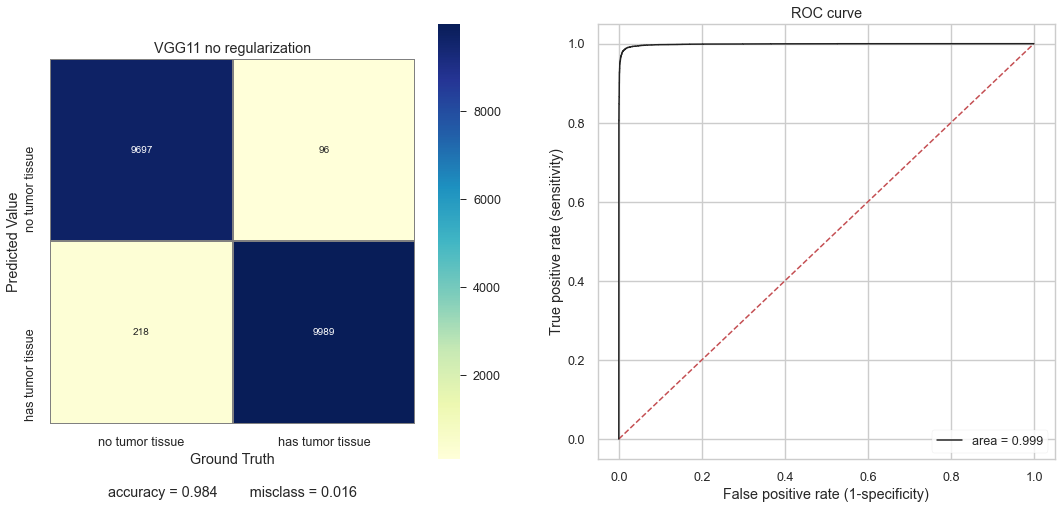

<Figure size 432x288 with 0 Axes>

In [34]:
seaborn_cm(c_matrix, classes[0], classes[1], 'VGG11 no regularization', test_gen, predictions)

For brevity, performance metric data from sections 9.1 - 9.7 will be summarized in section 10.

***
## Basic VGG-11 with Batch Normalization
***

Now we will try to standardize the data by adding batch normalization between the CNN layers.</br>

epochs = 40</br>

batchsize = 64</br>

optimizer = SGD (stochastic gradient descent)</br>

learning rate = 0.001</br>

momentum = 0.9</br>

hidden/dense layer activation = relu (rectified linear unit)</br>

output activation = softmax</br>

batchnorm = True



### Instantiate and Plot Model

In [26]:
import VGG11Net
# Instantiate Model
model_vgg11_bn = VGG11Net.CNN_BASIC_VGG11((IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS), batchnorm=True)
model_vgg11_bn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 96, 96, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 48, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 128)       512       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 256)      

In [28]:
# Plot model
model_plotter(model_vgg11_bn, 'model_vgg11_bn.png')

### Specify Model Filename and Create Checkpoint

In [29]:
filepath = "model_vgg11_bn.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_accuracy',
                             verbose = 1, 
                             save_best_only = True,
                             mode = 'max')
callbacks_list = [checkpoint]

### Train Model

In [30]:
start_time = time.time()
history_vgg11_bn = model_vgg11_bn.fit_generator(generator = train_gen,
                                     steps_per_epoch = train_steps,
                                     validation_data = valid_gen,
                                     validation_steps = valid_steps,
                                     epochs = epochs,
                                     verbose = 1,
                                     callbacks = callbacks_list)
print('Run time for {} epochs: {:.2f} minutes'.format(20, (1/60)*(time.time()-start_time)))

Epoch 1/40
1250/1250 [==============================] - 175s 140ms/step - loss: 15.5623 - accuracy: 0.8288 - val_loss: 15.2056 - val_accuracy: 0.8171

Epoch 00001: val_accuracy improved from -inf to 0.81715, saving model to model_vgg11_bn.h5
Epoch 2/40
1250/1250 [==============================] - 130s 104ms/step - loss: 14.7319 - accuracy: 0.8778 - val_loss: 14.4408 - val_accuracy: 0.8267 loss: 14.7485 - accura

Epoch 00002: val_accuracy improved from 0.81715 to 0.82675, saving model to model_vgg11_bn.h5
Epoch 3/40
1250/1250 [==============================] - 130s 104ms/step - loss: 13.9759 - accuracy: 0.9044 - val_loss: 13.7060 - val_accuracy: 0.7999

Epoch 00003: val_accuracy did not improve from 0.82675
Epoch 4/40
1250/1250 [==============================] - 130s 104ms/step - loss: 13.2703 - accuracy: 0.9229 - val_loss: 13.0792 - val_accuracy: 0.7751

Epoch 00004: val_accuracy did not improve from 0.82675
Epoch 5/40
1250/1250 [==============================] - 130s 104ms/step - loss

### Model Diagnostics

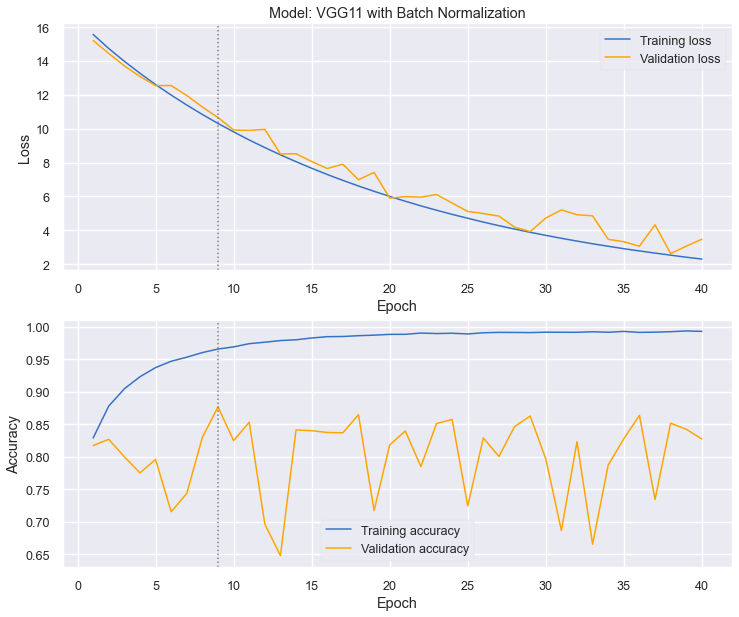

In [31]:
summarize_diagnostics(history_vgg11_bn, 'VGG11 with Batch Normalization')

### Predictions and Report on Test Data

In [32]:
# Load model parameters
model_vgg11_bn.load_weights(filepath)
predictions = model_vgg11_bn.predict_generator(test_gen, steps = len(x_test), verbose = 1)

20000/20000 [==============================] - 75s 4ms/step


In [33]:
classes = ['no tumor tissue', 'has tumor tissue']
c_matrix = prediction_report(predictions, classes, test_gen)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}
                  precision    recall  f1-score   support

 no tumor tissue       0.97      0.93      0.95      9915
has tumor tissue       0.94      0.97      0.95     10085

        accuracy                           0.95     20000
       macro avg       0.95      0.95      0.95     20000
    weighted avg       0.95      0.95      0.95     20000



### Confusion Matrix and ROC 

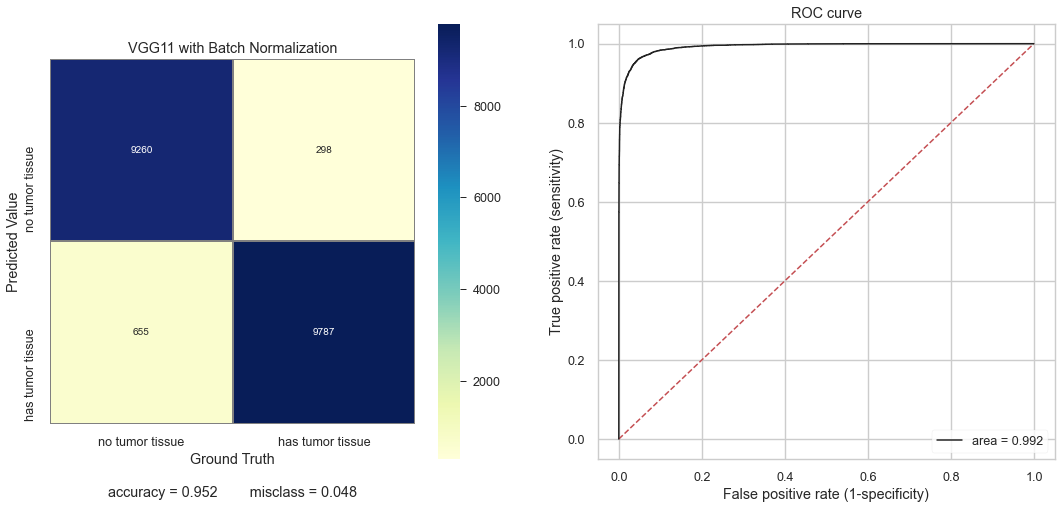

<Figure size 432x288 with 0 Axes>

In [34]:
seaborn_cm(c_matrix, classes[0], classes[1], 'VGG11 with Batch Normalization', test_gen, predictions)

***
## Basic VGG-11 with Dropout
***

In this section, we will evaluate dropout regularization for the CNN network.</br>

epochs = 40</br>

batchsize = 64</br>

optimizer = SGD (stochastic gradient descent)</br>

learning rate = 0.001</br>

momentum = 0.9</br>

hidden/dense layer activation = relu (rectified linear unit)</br>

output activation = softmax</br>

dropout = True (20%)



### Instantiate and Plot Model

In [35]:
import VGG11Net
# Instantiate Model
model_vgg11_do = VGG11Net.CNN_BASIC_VGG11((IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS), dropout=True)
model_vgg11_do.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 96, 96, 64)        1792      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 256)      

In [36]:
# Plot model
model_plotter(model_vgg11_do, 'model_vgg11_do.png')

### Specify Model Filename and Create Checkpoint

In [37]:
filepath = "model_vgg11_do.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_accuracy',
                             verbose = 1, 
                             save_best_only = True,
                             mode = 'max')
callbacks_list = [checkpoint]

### Train Model

In [38]:
start_time = time.time()
history_vgg11_do = model_vgg11_do.fit_generator(generator = train_gen,
                                     steps_per_epoch = train_steps,
                                     validation_data = valid_gen,
                                     validation_steps = valid_steps,
                                     epochs = epochs,
                                     verbose = 1,
                                     callbacks = callbacks_list)
print('Run time for {} epochs: {:.2f} minutes'.format(20, (1/60)*(time.time()-start_time)))

Epoch 1/40
1250/1250 [==============================] - 140s 112ms/step - loss: 22.8382 - accuracy: 0.5010 - val_loss: 21.0411 - val_accuracy: 0.4992

Epoch 00001: val_accuracy improved from -inf to 0.49915, saving model to model_vgg11_do.h5
Epoch 2/40
1250/1250 [==============================] - 85s 68ms/step - loss: 22.1026 - accuracy: 0.5011 - val_loss: 21.2806 - val_accuracy: 0.4992r

Epoch 00002: val_accuracy did not improve from 0.49915
Epoch 3/40
1250/1250 [==============================] - 85s 68ms/step - loss: 19.2875 - accuracy: 0.5071 - val_loss: 14.0728 - val_accuracy: 0.4992

Epoch 00003: val_accuracy did not improve from 0.49915
Epoch 4/40
1250/1250 [==============================] - 86s 69ms/step - loss: 13.5998 - accuracy: 0.7240 - val_loss: 13.3574 - val_accuracy: 0.6184

Epoch 00004: val_accuracy improved from 0.49915 to 0.61840, saving model to model_vgg11_do.h5
Epoch 5/40
1250/1250 [==============================] - 85s 68ms/step - loss: 12.8905 - accuracy: 0.7833 -

1250/1250 [==============================] - 91s 72ms/step - loss: 2.6484 - accuracy: 0.9168 - val_loss: 2.6325 - val_accuracy: 0.8695

Epoch 00038: val_accuracy did not improve from 0.87435
Epoch 39/40
1250/1250 [==============================] - 91s 73ms/step - loss: 2.5268 - accuracy: 0.9205 - val_loss: 2.5005 - val_accuracy: 0.8857

Epoch 00039: val_accuracy improved from 0.87435 to 0.88575, saving model to model_vgg11_do.h5
Epoch 40/40
1250/1250 [==============================] - 91s 73ms/step - loss: 2.4155 - accuracy: 0.9211 - val_loss: 2.3724 - val_accuracy: 0.8766

Epoch 00040: val_accuracy did not improve from 0.88575
Run time for 20 epochs: 60.26 minutes


### Model Diagnostics

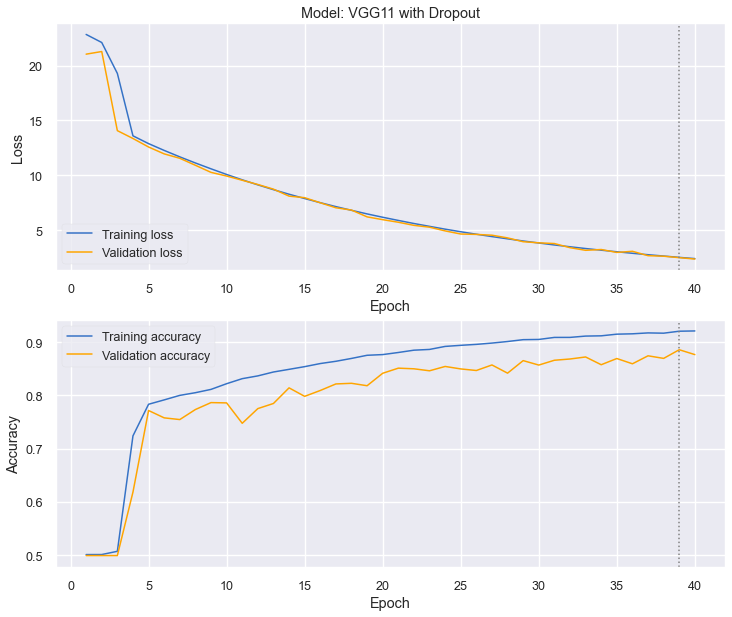

In [39]:
summarize_diagnostics(history_vgg11_do, 'VGG11 with Dropout')

### Predictions and Report on Test Data

In [40]:
# Load model parameters
model_vgg11_do.load_weights(filepath)
predictions = model_vgg11_do.predict_generator(test_gen, steps = len(x_test), verbose = 1)

20000/20000 [==============================] - 64s 3ms/step


In [41]:
classes = ['no tumor tissue', 'has tumor tissue']
c_matrix = prediction_report(predictions, classes, test_gen)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}
                  precision    recall  f1-score   support

 no tumor tissue       0.95      0.91      0.93      9915
has tumor tissue       0.91      0.95      0.93     10085

        accuracy                           0.93     20000
       macro avg       0.93      0.93      0.93     20000
    weighted avg       0.93      0.93      0.93     20000



### Confusion Matrix and ROC

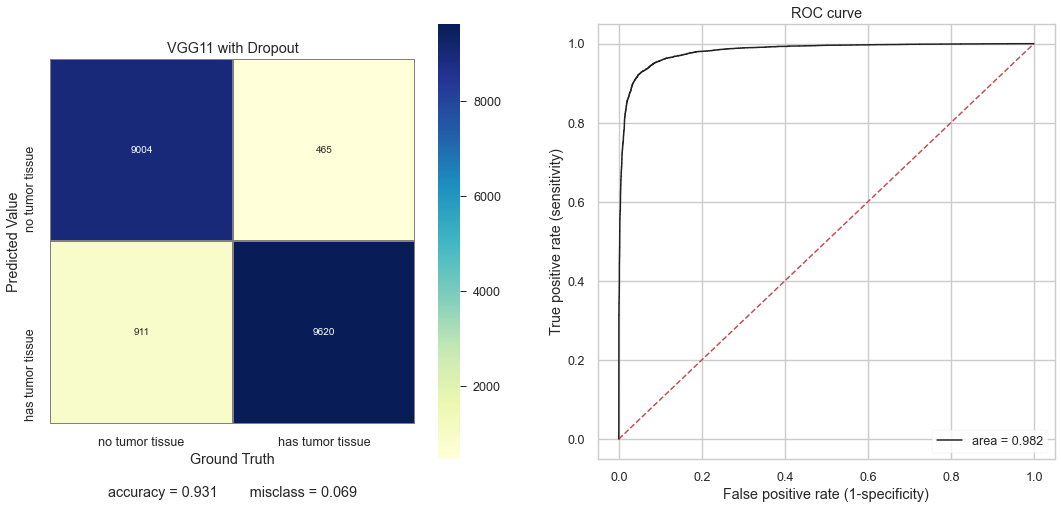

<Figure size 432x288 with 0 Axes>

In [42]:
seaborn_cm(c_matrix, classes[0], classes[1], 'VGG11 with Dropout', test_gen, predictions)

***
## Basic VGG-11 with Dropout and Scheduled Learning Rate
***

In this section, we will evaluate the influence of a decaying learning rate using the *decay* parameter that can be specified for Keras's SGD optimizer.</br>

epochs = 40</br>

batchsize = 64</br>

optimizer = SGD (stochastic gradient descent)</br>

learning rate = 0.001</br>

momentum = 0.75</br>

decay = 0.001/40</br>

hidden/dense layer activation = relu (rectified linear unit)</br>

output activation = softmax</br>

dropout = True (20%)



### Instantiate and Plot Model

In [25]:
# Instantiate Model
import VGG11Net
model_vgg11_do_lrdecay = VGG11Net.CNN_BASIC_VGG11((IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS), 
                                                      lr = 0.001, 
                                                      momentum=0.75, 
                                                      decay = 0.001/epochs, 
                                                      dropout=True, 
                                                      batchnorm=False)
model_vgg11_do_lrdecay.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 96, 96, 64)        1792      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 256)      

### Specify Model Filename and Create Checkpoint

In [26]:
filepath = "model_vgg11_do_lrdecay.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_accuracy',
                             verbose = 1, 
                             save_best_only = True,
                             mode = 'max')
callbacks_list = [checkpoint]

### Train Model

In [27]:
start_time = time.time()
history_vgg11_do_lrdecay = model_vgg11_do_lrdecay.fit_generator(generator = train_gen,
                                     steps_per_epoch = train_steps,
                                     validation_data = valid_gen,
                                     validation_steps = valid_steps,
                                     epochs = epochs,
                                     verbose = 1,
                                     callbacks = callbacks_list)
print('Run time for {} epochs: {:.2f} minutes'.format(20, (1/60)*(time.time()-start_time)))

Epoch 1/40
1250/1250 [==============================] - 89s 71ms/step - loss: 15.9823 - accuracy: 0.6870 - val_loss: 15.9868 - val_accuracy: 0.5019

Epoch 00001: val_accuracy improved from -inf to 0.50190, saving model to model_vgg11_do_lrdecay.h5
Epoch 2/40
1250/1250 [==============================] - 87s 69ms/step - loss: 15.5903 - accuracy: 0.7710 - val_loss: 15.6372 - val_accuracy: 0.5986

Epoch 00002: val_accuracy improved from 0.50190 to 0.59865, saving model to model_vgg11_do_lrdecay.h5
Epoch 3/40
1250/1250 [==============================] - 88s 70ms/step - loss: 15.2909 - accuracy: 0.7818 - val_loss: 15.2662 - val_accuracy: 0.6683

Epoch 00003: val_accuracy improved from 0.59865 to 0.66835, saving model to model_vgg11_do_lrdecay.h5
Epoch 4/40
1250/1250 [==============================] - 88s 70ms/step - loss: 15.0138 - accuracy: 0.7872 - val_loss: 14.9379 - val_accuracy: 0.6881

Epoch 00004: val_accuracy improved from 0.66835 to 0.68810, saving model to model_vgg11_do_lrdecay.h5

### Model Diagnostics

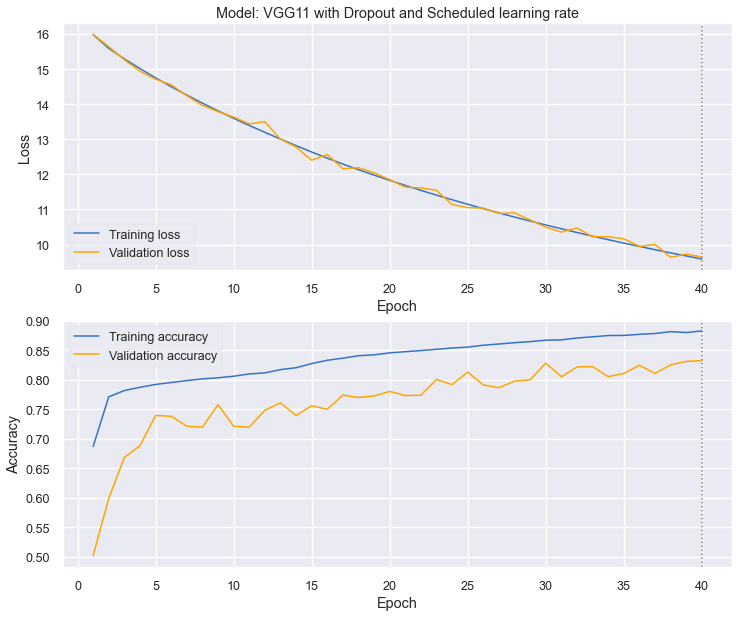

In [28]:
summarize_diagnostics(history_vgg11_do_lrdecay, 'VGG11 with Dropout and Scheduled learning rate')

### Predictions and Report on Test Data

In [29]:
# Load model parameters
model_vgg11_do_lrdecay.load_weights(filepath)
predictions = model_vgg11_do_lrdecay.predict_generator(test_gen, steps = len(x_test), verbose = 1)

20000/20000 [==============================] - 91s 5ms/step


In [30]:
classes = ['no tumor tissue', 'has tumor tissue']
c_matrix = prediction_report(predictions, classes, test_gen)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}
                  precision    recall  f1-score   support

 no tumor tissue       0.87      0.88      0.87      9915
has tumor tissue       0.88      0.88      0.88     10085

        accuracy                           0.88     20000
       macro avg       0.88      0.88      0.88     20000
    weighted avg       0.88      0.88      0.88     20000



### Confusion Matrix and ROC

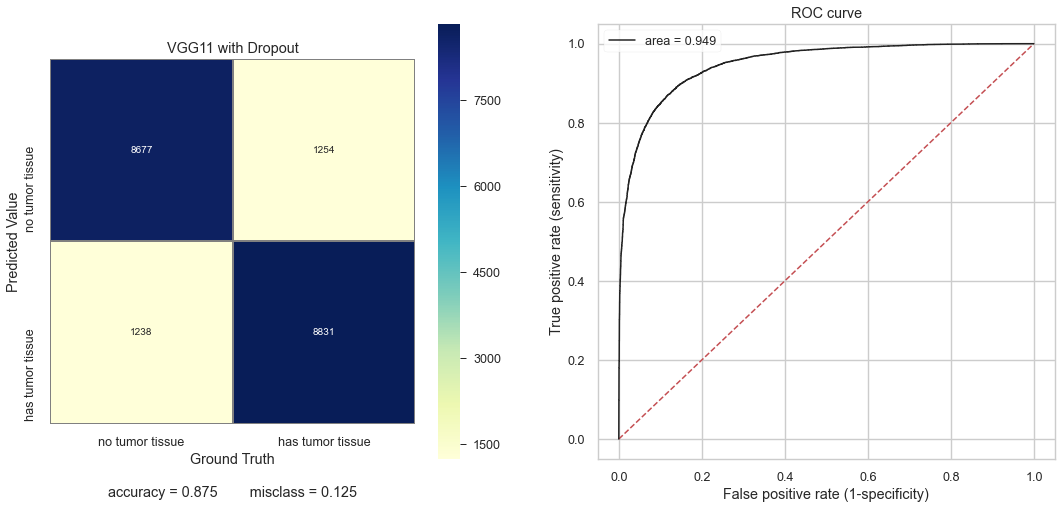

<Figure size 432x288 with 0 Axes>

In [31]:
seaborn_cm(c_matrix, classes[0], classes[1], 'VGG11 with Dropout and Scheduled Learning Rate', test_gen, predictions)

***
## Basic VGG-11 with Dropout and Batch Size = 32
***

Here, we will evaluate the influence of a reduced batch size.</br>

epochs = 40</br>

batchsize = 32</br>

optimizer = SGD (stochastic gradient descent)</br>

learning rate = 0.001</br>

momentum = 0.9</br>

hidden/dense layer activation = relu (rectified linear unit)</br>

output activation = softmax</br>

dropout = True (20%)



In [29]:
train_batch_size = 32
valid_batch_size = 32
epochs = 40

train_steps = np.ceil(number_train_samples / train_batch_size)
valid_steps = np.ceil(number_valid_samples / valid_batch_size)

print('Number of epochs = {}'.format(epochs))
print('Training steps   = {}'.format(int(train_steps)))
print('Validation steps = {}'.format(int(valid_steps)))

Number of epochs = 40
Training steps   = 2500
Validation steps = 625


### Instantiate and Plot Model

In [19]:
import VGG11Net
# Instantiate Model
model_vgg11_do_smallbatch = VGG11Net.CNN_BASIC_VGG11((IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS), dropout=True)
model_vgg11_do_smallbatch.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)      

### Specify Model Filename and Create Checkpoint

In [20]:
filepath = "model_vgg11_do_smallbatch.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_accuracy',
                             verbose = 1, 
                             save_best_only = True,
                             mode = 'max')
callbacks_list = [checkpoint]

### Train Model

In [21]:
start_time = time.time()
history_vgg11_do_smallbatch= model_vgg11_do_smallbatch.fit_generator(generator = train_gen,
                                     steps_per_epoch = train_steps,
                                     validation_data = valid_gen,
                                     validation_steps = valid_steps,
                                     epochs = epochs,
                                     verbose = 1,
                                     callbacks = callbacks_list)
print('Run time for {} epochs: {:.2f} minutes'.format(20, (1/60)*(time.time()-start_time)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/40
2500/2500 [==============================] - 176s 70ms/step - loss: 22.5006 - accuracy: 0.4989 - val_loss: 19.3978 - val_accuracy: 0.5008

Epoch 00001: val_accuracy improved from -inf to 0.50080, saving model to model_vgg11_do_smallbatch.h5
Epoch 2/40
2500/2500 [==============================] - 174s 70ms/step - loss: 16.8103 - accuracy: 0.6024 - val_loss: 13.3453 - val_accuracy: 0.5545

Epoch 00002: val_accuracy improved from 0.50080 to 0.55454, saving model to model_vgg11_do_smallbatch.h5
Epoch 3/40
2500/2500 [==============================] - 175s 70ms/step - loss: 12.5893 - accuracy: 0.7812 - val_loss: 12.1498 - val_accuracy: 0.7160

Epoch 00003: val_accuracy improved from 0.55454 to 0.71597, saving model to model_vgg11_do_smallbatch.h5
Epoch 4/40
2500/2500 [==============================] - 175s 70ms/step - loss: 11.4078 - accuracy: 0.8003 - val_loss: 10.9388 - val_accuracy: 0.

### Model Diagnostics

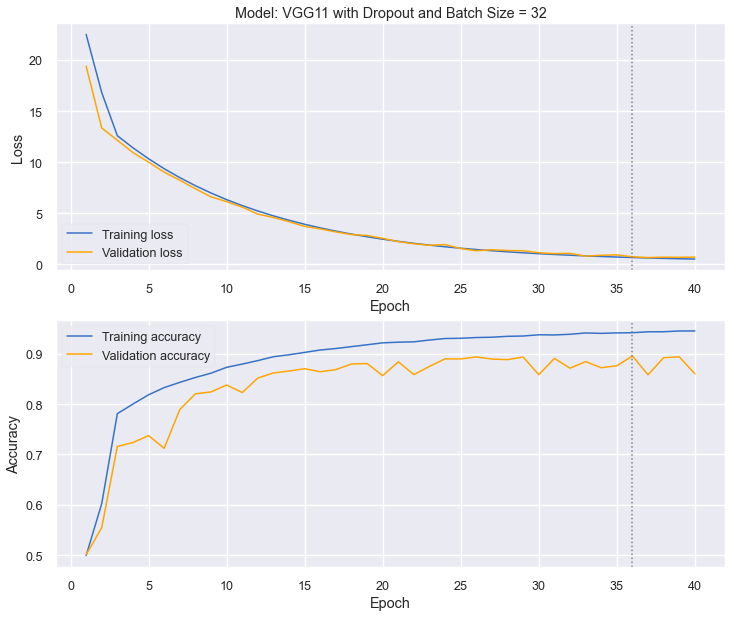

In [22]:
summarize_diagnostics(history_vgg11_do_smallbatch, 'VGG11 with Dropout and Batch Size = 32')

### Predictions and Report on Test Data

In [23]:
# Load model parameters
model_vgg11_do_smallbatch.load_weights(filepath)
predictions = model_vgg11_do_smallbatch.predict_generator(test_gen, steps = len(x_test), verbose = 1)

20000/20000 [==============================] - 64s 3ms/step


In [24]:
classes = ['no tumor tissue', 'has tumor tissue']
c_matrix = prediction_report(predictions, classes, test_gen)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}
                  precision    recall  f1-score   support

 no tumor tissue       0.96      0.93      0.95      9915
has tumor tissue       0.94      0.96      0.95     10085

        accuracy                           0.95     20000
       macro avg       0.95      0.95      0.95     20000
    weighted avg       0.95      0.95      0.95     20000



### Confusion Matrix and ROC

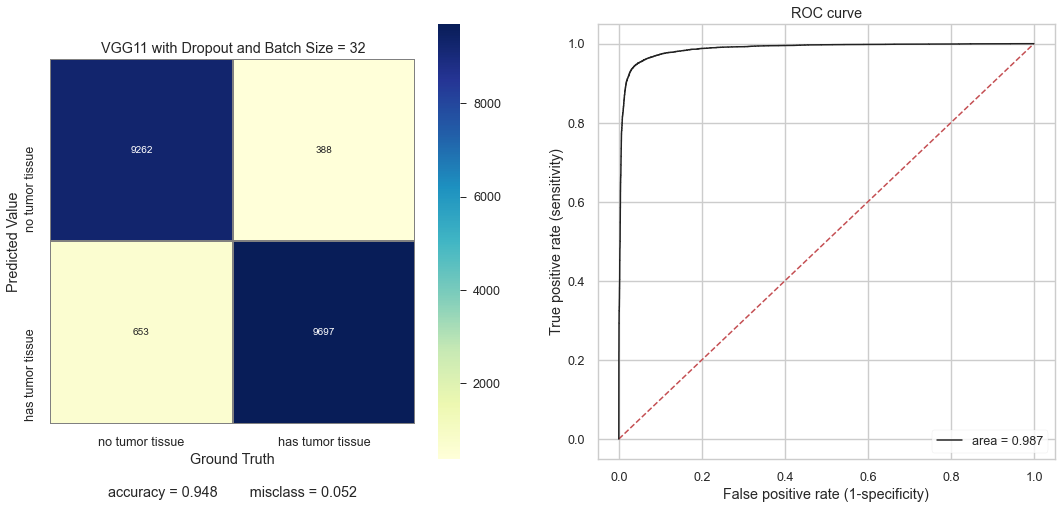

<Figure size 432x288 with 0 Axes>

In [25]:
seaborn_cm(c_matrix, classes[0], classes[1], 'VGG11 with Dropout and Batch Size = 32', test_gen, predictions)

***
## Basic VGG-11 with Dropout, Batch Size = 32, ELU activation function (CNN and dense layers)
***

In this section, we will evaluate the influence applying a different hidden layer activation function. Specifically, we will evaluate the exponential linear unit or the ELU function.</br>

epochs = 40</br>

batchsize = 64</br>

optimizer = SGD (stochastic gradient descent)</br>

learning rate = 0.001</br>

momentum = 0.9</br>

hidden/dense layer activation = elu (exponential linear unit)</br>

output activation = softmax</br>

dropout = True (20%)

In [18]:
train_batch_size = 32
valid_batch_size = 32
epochs = 40

train_steps = np.ceil(number_train_samples / train_batch_size)
valid_steps = np.ceil(number_valid_samples / valid_batch_size)

print('Number of epochs = {}'.format(epochs))
print('Training steps   = {}'.format(int(train_steps)))
print('Validation steps = {}'.format(int(valid_steps)))

Number of epochs = 40
Training steps   = 2500
Validation steps = 625


### Instantiate and Plot Model

In [19]:
import VGG11Net
# Instantiate Model
model_vgg11_do_smallbatch_ELU = VGG11Net.CNN_BASIC_VGG11((IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS), 
                                                         dropout=True, 
                                                         activation_cnn = 'elu', 
                                                         activation_dense = 'elu')
model_vgg11_do_smallbatch_ELU.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)      

### Specify Model Filename and Create Checkpoint

In [20]:
filepath = "model_vgg11_do_smallbatch_ELU.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_accuracy',
                             verbose = 1, 
                             save_best_only = True,
                             mode = 'max')
callbacks_list = [checkpoint]

### Train Model

In [21]:
start_time = time.time()
history_vgg11_do_smallbatch_ELU = model_vgg11_do_smallbatch_ELU.fit_generator(generator = train_gen,
                                     steps_per_epoch = train_steps,
                                     validation_data = valid_gen,
                                     validation_steps = valid_steps,
                                     epochs = epochs,
                                     verbose = 1,
                                     callbacks = callbacks_list)
print('Run time for {} epochs: {:.2f} minutes'.format(20, (1/60)*(time.time()-start_time)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/40
2500/2500 [==============================] - 211s 84ms/step - loss: 22.4692 - accuracy: 0.5010 - val_loss: 23.6825 - val_accuracy: 0.4991

Epoch 00001: val_accuracy improved from -inf to 0.49915, saving model to model_vgg11_do_smallbatch_ELU.h5
Epoch 2/40
2500/2500 [==============================] - 173s 69ms/step - loss: 21.0629 - accuracy: 0.5011 - val_loss: 20.1806 - val_accuracy: 0.4990

Epoch 00002: val_accuracy did not improve from 0.49915
Epoch 3/40
2500/2500 [==============================] - 173s 69ms/step - loss: 19.7884 - accuracy: 0.5011 - val_loss: 19.2091 - val_accuracy: 0.4994

Epoch 00003: val_accuracy improved from 0.49915 to 0.49945, saving model to model_vgg11_do_smallbatch_ELU.h5
Epoch 4/40
2500/2500 [==============================] - 174s 69ms/step - loss: 18.6353 - accuracy: 0.5011 - val_loss: 18.5933 - val_accuracy: 0.4991

Epoch 00004: val_accuracy did not im

2500/2500 [==============================] - 172s 69ms/step - loss: 0.5928 - accuracy: 0.9840 - val_loss: 1.1108 - val_accuracy: 0.7883

Epoch 00037: val_accuracy did not improve from 0.85064
Epoch 38/40
2500/2500 [==============================] - 173s 69ms/step - loss: 0.5547 - accuracy: 0.9841 - val_loss: 1.0652 - val_accuracy: 0.7941

Epoch 00038: val_accuracy did not improve from 0.85064
Epoch 39/40
2500/2500 [==============================] - 173s 69ms/step - loss: 0.5163 - accuracy: 0.9859 - val_loss: 1.2393 - val_accuracy: 0.7989

Epoch 00039: val_accuracy did not improve from 0.85064
Epoch 40/40
2500/2500 [==============================] - 172s 69ms/step - loss: 0.4863 - accuracy: 0.9855 - val_loss: 1.7733 - val_accuracy: 0.7818

Epoch 00040: val_accuracy did not improve from 0.85064
Run time for 20 epochs: 116.43 minutes


### Model Diagnostics

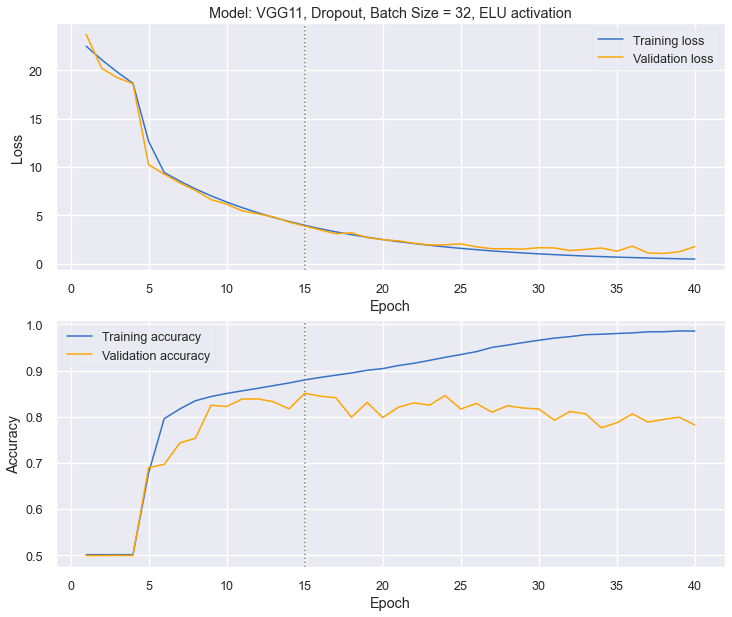

In [22]:
summarize_diagnostics(history_vgg11_do_smallbatch_ELU, 'VGG11, Dropout, Batch Size = 32, ELU activation')

### Predictions and Report on Test Data

In [23]:
# Load model parameters
model_vgg11_do_smallbatch_ELU.load_weights(filepath)
predictions = model_vgg11_do_smallbatch_ELU.predict_generator(test_gen, steps = len(x_test), verbose = 1)

20000/20000 [==============================] - 89s 4ms/step


In [24]:
classes = ['no tumor tissue', 'has tumor tissue']
c_matrix = prediction_report(predictions, classes, test_gen)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}
                  precision    recall  f1-score   support

 no tumor tissue       0.91      0.87      0.89      9915
has tumor tissue       0.88      0.92      0.90     10085

        accuracy                           0.89     20000
       macro avg       0.89      0.89      0.89     20000
    weighted avg       0.89      0.89      0.89     20000



### Confusion Matrix and ROC

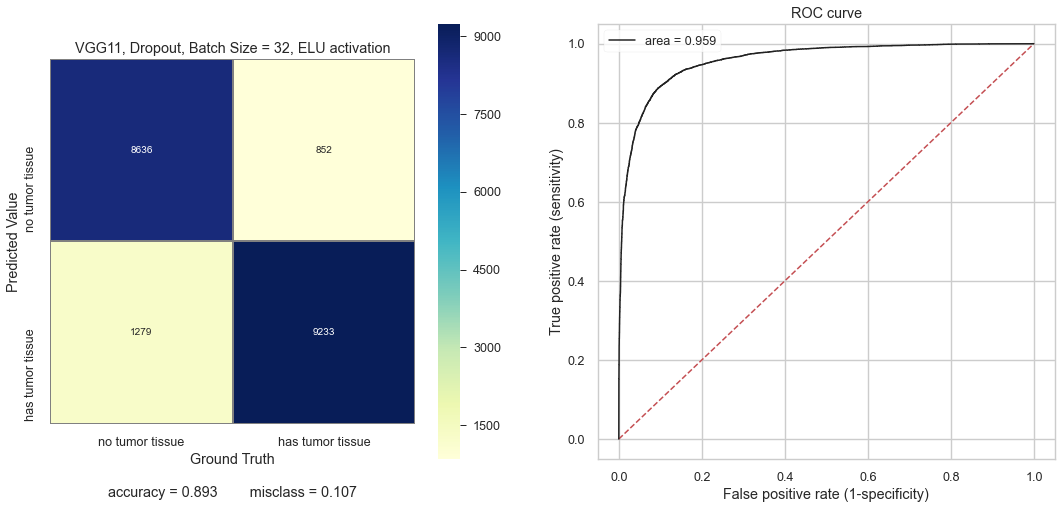

<Figure size 432x288 with 0 Axes>

In [25]:
seaborn_cm(c_matrix, classes[0], classes[1], 'VGG11, Dropout, Batch Size = 32, ELU activation', test_gen, predictions)

***
## Basic VGG-11 with Dropout, Batch Size = 32, ReLU Activation (CNN and dense layers), Sigmoid Activation (Output)
***

In this section, we will evaluate the effect of changing the output activation function from *softmax* to *sigmoid*</br>

epochs = 40</br>

batchsize = 64</br>

optimizer = SGD (stochastic gradient descent)</br>

learning rate = 0.001</br>

momentum = 0.75</br>

hidden/dense layer activation = relu (rectified linear unit)</br>

output activation = sigmoid</br>

dropout = true (20%)



In [36]:
# Ensure batch size = 32, and training and validation steps are calculated correctly
train_batch_size = 32
valid_batch_size = 32
epochs = 40

train_steps = np.ceil(number_train_samples / train_batch_size)
valid_steps = np.ceil(number_valid_samples / valid_batch_size)

print('Number of epochs = {}'.format(epochs))
print('Training steps   = {}'.format(int(train_steps)))
print('Validation steps = {}'.format(int(valid_steps)))

Number of epochs = 40
Training steps   = 2500
Validation steps = 625


### Instantiate and Plot Model

In [37]:
import VGG11Net
# Instantiate Model
model_vgg11_do_sigmoid = VGG11Net.CNN_BASIC_VGG11((IMAGE_SIZE,IMAGE_SIZE,IMAGE_CHANNELS), dropout=True, activation_out = 'sigmoid')
model_vgg11_do_sigmoid.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 96, 96, 64)        1792      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 24, 24, 256)      

### Specify Model Filename and Create Checkpoint

In [39]:
filepath = "model_vgg11_do_sigmoid.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_accuracy',
                             verbose = 1, 
                             save_best_only = True,
                             mode = 'max')
callbacks_list = [checkpoint]

### Train Model

In [40]:
start_time = time.time()
history_vgg11_do_sigmoid = model_vgg11_do_sigmoid.fit_generator(generator = train_gen,
                                     steps_per_epoch = train_steps,
                                     validation_data = valid_gen,
                                     validation_steps = valid_steps,
                                     epochs = epochs,
                                     verbose = 1,
                                     callbacks = callbacks_list)
print('Run time for {} epochs: {:.2f} minutes'.format(20, (1/60)*(time.time()-start_time)))

Epoch 1/40
2500/2500 [==============================] - 210s 84ms/step - loss: 15.2595 - accuracy: 0.7666 - val_loss: 14.5073 - val_accuracy: 0.7876

Epoch 00001: val_accuracy improved from -inf to 0.78758, saving model to model_vgg11_do_sigmoid.h5
Epoch 2/40
2500/2500 [==============================] - 171s 69ms/step - loss: 13.8070 - accuracy: 0.7997 - val_loss: 13.0750 - val_accuracy: 0.7879

Epoch 00002: val_accuracy improved from 0.78758 to 0.78789, saving model to model_vgg11_do_sigmoid.h5
Epoch 3/40
2500/2500 [==============================] - 172s 69ms/step - loss: 12.5090 - accuracy: 0.8156 - val_loss: 12.1143 - val_accuracy: 0.7503

Epoch 00003: val_accuracy did not improve from 0.78789
Epoch 4/40
2500/2500 [==============================] - 172s 69ms/step - loss: 11.3280 - accuracy: 0.8318 - val_loss: 10.8855 - val_accuracy: 0.7912ccuracy: 0. - ETA: 0s - loss: 11.3292 - accuracy: 

Epoch 00004: val_accuracy improved from 0.78789 to 0.79124, saving model to model_vgg11_do_sig

2500/2500 [==============================] - 168s 67ms/step - loss: 0.5885 - accuracy: 0.9465 - val_loss: 0.6190 - val_accuracy: 0.8802

Epoch 00038: val_accuracy did not improve from 0.89516
Epoch 39/40
2500/2500 [==============================] - 168s 67ms/step - loss: 0.5542 - accuracy: 0.9468 - val_loss: 0.7351 - val_accuracy: 0.8861

Epoch 00039: val_accuracy did not improve from 0.89516
Epoch 40/40
2500/2500 [==============================] - 168s 67ms/step - loss: 0.5223 - accuracy: 0.9470 - val_loss: 0.5929 - val_accuracy: 0.8893

Epoch 00040: val_accuracy did not improve from 0.89516
Run time for 20 epochs: 118.17 minutes


### Model Diagnostics

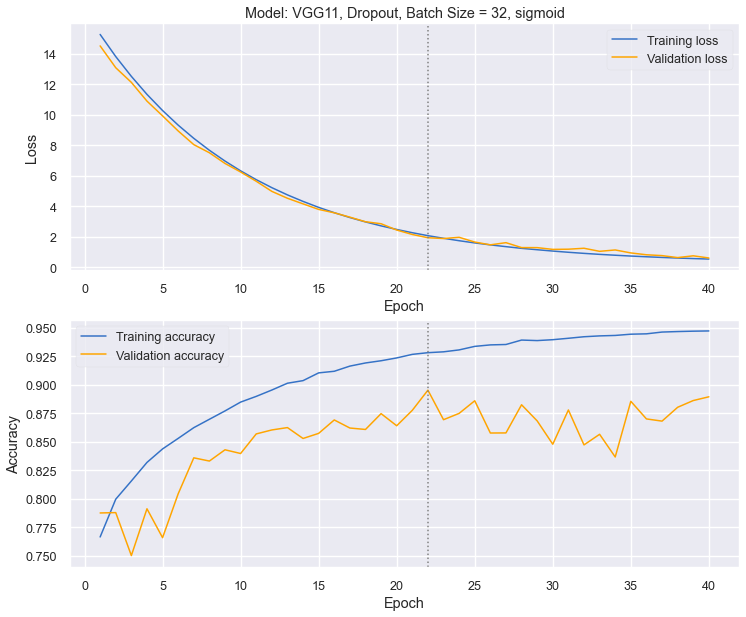

In [41]:
summarize_diagnostics(history_vgg11_do_sigmoid, 'VGG11, Dropout, Batch Size = 32, sigmoid')

### Predictions and Report on Test Data

In [42]:
# Load model parameters
model_vgg11_do_sigmoid.load_weights(filepath)
predictions = model_vgg11_do_sigmoid.predict_generator(test_gen, steps = len(x_test), verbose = 1)

20000/20000 [==============================] - 64s 3ms/step


In [43]:
classes = ['no tumor tissue', 'has tumor tissue']
c_matrix = prediction_report(predictions, classes, test_gen)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}
                  precision    recall  f1-score   support

 no tumor tissue       0.95      0.92      0.94      9915
has tumor tissue       0.92      0.96      0.94     10085

        accuracy                           0.94     20000
       macro avg       0.94      0.94      0.94     20000
    weighted avg       0.94      0.94      0.94     20000



### Confusion Matrix and ROC

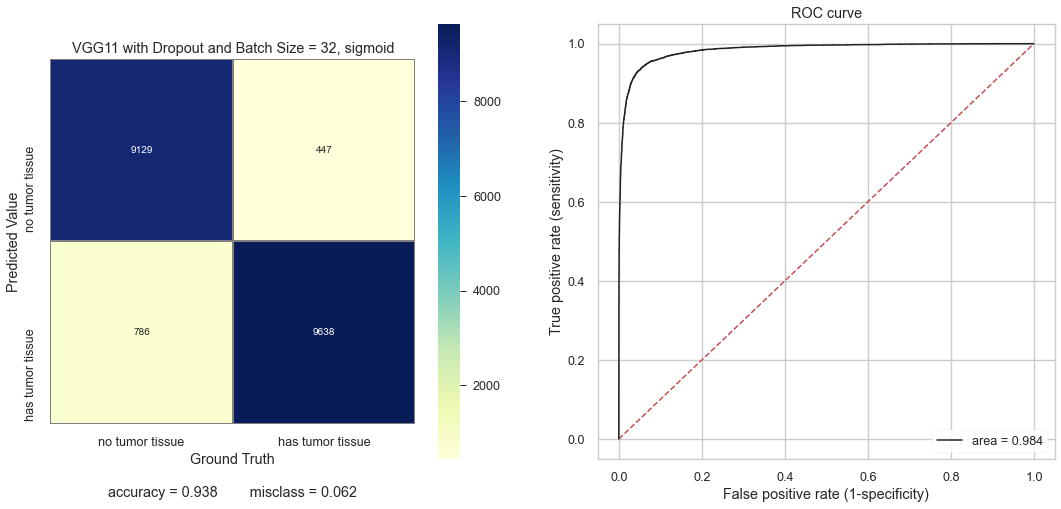

<Figure size 432x288 with 0 Axes>

In [44]:
seaborn_cm(c_matrix, classes[0], classes[1], 'VGG11 with Dropout and Batch Size = 32, sigmoid', test_gen, predictions)

***
# Model Summary 
***

Generate a tabulated data summary in Pandas to facilitate data analysis

In [5]:
import pandas as pd
data = {'CNN Architecture': ['VGG-11']*7,
        'Regularization': ['None', 'Batch Normalization', 'Dropout (20%)', 'Dropout (20%)', 'Dropout (20%)', 'Dropout (20%)','Dropout (20%)'],
        'Optimizer': ['SGD', 'SGD', 'SGD', 'SGD with scheduled learning', 'SGD', 'SGD', 'SGD'],
        'Batch Size': [64, 64, 64, 64, 32, 32, 32],
        'Epochs': [40]*7,
        'Hidden layer activation function': ['ReLU', 'ReLU', 'ReLU', 'ReLU', 'ReLU', 'ELU', 'ReLU'],
        'Output activation function': ['softmax', 'softmax', 'softmax', 'softmax', 'softmax', 'softmax', 'sigmoid'],
        'Accuracy': [0.98, 0.95, 0.93, 0.88, 0.95, 0.89, 0.94],
        'Recall (tumor +ve)': [0.99, 0.97, 0.95, 0.88, 0.96, 0.92, 0.96],
        'ROC AUC': [0.999, 0.992, 0.980, 0.950, 0.987, 0.959, 0.984]}

results_dict = pd.DataFrame.from_dict(data)
results_dict

CNN Architecture       Regularization                    Optimizer  \
0           VGG-11                 None                          SGD   
1           VGG-11  Batch Normalization                          SGD   
2           VGG-11        Dropout (20%)                          SGD   
3           VGG-11        Dropout (20%)  SGD with scheduled learning   
4           VGG-11        Dropout (20%)                          SGD   
5           VGG-11        Dropout (20%)                          SGD   
6           VGG-11        Dropout (20%)                          SGD   

   Batch Size  Epochs Hidden layer activation function  \
0          64      40                             ReLU   
1          64      40                             ReLU   
2          64      40                             ReLU   
3          64      40                             ReLU   
4          32      40                             ReLU   
5          32      40                              ELU   
6          32      40                             ReLU   

  Output activation function  Accuracy  Recall (tumor +ve)  ROC AUC  
0                    softmax      0.98                0.99    0.999  
1                    softmax      0.95                0.97    0.992  
2                    softmax      0.93                0.95    0.980  
3                    softmax      0.88                0.88    0.950  
4                    softmax      0.95                0.96    0.987  
5                    softmax      0.89                0.92    0.959  
6                    sigmoid      0.94                0.96    0.984

## Noteworthy Observations

* Considering the accuracy, recall (+ve label), and ROC AUC metrics, the first basic VGG11-Net model evaluated in section 9.1 showed the most favorable performance.</br>
</br>

* The VGG11-Net models evaluated with batch normalization (section 9.2) and hidden layer ELU activation (section 9.6) showed least favorable performance when interpreting the same metrics.</br>
</br>

* However, it is critical to pay close attention to the 'Model Diagnostics' within each model evaluation section. More specifcally, the temporal evolution and stablity of the training and validation loss and accuracy curves must be considered.</br>
</br>

* For example, for the model under evaluation in section 9.1, the training and validation loss curves closely follow a similar trajectory. However, there is a ~16% discrepancy between the training and validation accuracy cruves, suggesting model overfitting during training.</br>
</br>

* Similarly, using batch normalization (section 9.2) the resulting model showed similar training and loss curve trajectories, a smooth growth in training accuracy, yet a valiadtion accuracy curve that oscillates wildly about an apprximate mean of 75%.</br>
</br>

* In comparison, the models evaluated in section 9.3 (dropout = True, batchsize = 64) and section 9.5 (dropout = Truw, batchsize = 32) showed improved agreement between both training and validation loss curves as well as their corresponding accuracy curves.</br>
</br>

* These models also resulted in favorable accuracy, recall (+ve label), and ROC AUC metrics.</br>





**Additional note**
As per Jason Brownlee's post titled 'A Gentle Introduction to Batch Normalization for Deep Neural Networks' (https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/) care was taken here to not instantiate a model with both batch normalization and dropout as regularization methods. 

***
# Moving Forward
***

Three separate VGG11-Net models were identified as potential candidates to be retrained and evaluated using the **full** PCam dataset. These are:</br>
</br>
* The basic VGG-11 Net (from section 9.1) based on its performance metrics</br>

* VGG-Net (from section 9.3) with batchsize of 64 and dropout regularization based on training and validation loss and accuracy curves</br>

* VGG-Net (from section 9.3) with batchsize of 32 and dropout regularization based on training and validation loss and accuracy curves</br>

The results from the model training using the full PCam datset can be found at the following notebook:</br>

https://github.com/aprescot1977/Thinkful-projects/blob/main/Prescot_PCAM_VGG11_FullData.ipynb 